# DATA WRANGLING PROJECT 

## Crime Stats
This notebook consists of the wrangling involved in `Crime Stats`

## Section 1: `Wrangling the Crime Data`

The steps are as follows:
 1. Loading and renaming the dataset
 2. Aggregating the columns
 3. Reshaping the dataframe into common structure
 4. Export into csv

In [1]:
#Loading the required libraries:
library (tidyverse)
library(lubridate)
library(zoo)
library(ggplot2)

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --

v ggplot2 3.2.1     v purrr   0.3.2
v tibble  2.1.3     v dplyr   0.8.3
v tidyr   0.8.3     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'lubridate'


The following object is masked from 'package:base':

    date



Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric




### Loading and Renaming the dataset

In [2]:
#Loading the file and selecting the columns

base_csv <- read_csv( "ARG_data.csv")

unclean_df <- base_csv %>% select(c(24,15,4))

unclean_df <- rename(unclean_df, Date = "Year Month", CrimeType = "Anzsoc Subdivision", 
                     PoliceStation = "Police Station",
                    )
unclean_df %>% glimpse()

Parsed with column specification:
cols(
  .default = col_character(),
  `Weapons filter` = col_logical(),
  `Number of Records` = col_double(),
  Victimisations = col_double()
)

See spec(...) for full column specifications.



Observations: 613,549
Variables: 3
$ Date          <chr> "7/1/2014", "7/1/2014", "7/1/2014", "7/1/2014", "7/1/...
$ PoliceStation <chr> "Kamo CPC", "Dunedin South", "Invercargill Central", ...
$ CrimeType     <chr> "Assault", "Assault", "Assault", "Assault", "Assault"...


### Aggregating the columns

In [3]:
#creating a function to add Year, Month, Quarter and aggregate the columns

add_ymq <- function(df){
            df %>%
                mutate(Year = year(df$Date), 
                       Month = month(df$Date),
                       Quarter = as.yearqtr(df$Date, format = "%Y-%m-%d")) %>%
                select(-c("Date")) %>%  #removing the "Date" column
                select(c(3,4,5,1,2))  #swlwcting the column in the required order
    }

wrangle_crime <- function(df) {
df %>% 
    mutate(Date = as.Date(Date,"%m/%d/%Y")) %>% 
    add_ymq() %>% 
    group_by(Year,Month,Quarter,PoliceStation) %>%
    summarise(CrimeCount = n())   #Counting the number of crimes
    }

### Reshaping the dataframe into common structure
so that it can be used in the data model with the rest of the enities.

In [4]:
final <- unclean_df %>% wrangle_crime() #using the created function to wrangle the data

final %>% head()

Year,Month,Quarter,PoliceStation,CrimeCount
<dbl>,<dbl>,<yearqtr>,<chr>,<int>
2014,7,2014 Q3,Akaroa,6
2014,7,2014 Q3,Alexandra,7
2014,7,2014 Q3,Amberley,7
2014,7,2014 Q3,Arthurs Pass,1
2014,7,2014 Q3,Ashburton,45
2014,7,2014 Q3,Auckland Airport,17


The below code can be executed if you want to see the output of the data after cleaning.

In [5]:
#Export the dataframe to a csv format

#write_csv(final,"Crime_cleaned.csv")

## Section 2: Web Scraping in Julia

Since the data we have now does not contain NZ_city information but Police Station only, we cannot map it to the International visitors data. So, we are going to scrap the address of the each police station from a webpage and use it to map with the International visitors data with the City as a key field.

#### `Refer the notenook attached "PoliceStation_Info-Julia.pynb" to get the web scraped data frame`

Execute the julia notebook and continue with the section 3 of 'Crime.ipynb'

## Section 3: Merging the Two datasets

Loading the exported file that was created using Julia from web scraping to wrangle further.

The steps are as follows:
 1. Loading the dataset
 2. Data Cleaning
 3. Merging the datasets
 3. Reshaping the dataframe into common structure
 4. Export into csv

### Loading the dataset

In [6]:
# Reading the scraped file in CSV file format to police_data dataframe

police_data = read_csv("Police_City_Output.csv")

Parsed with column specification:
cols(
  Police_station = col_character(),
  address = col_character()
)



### Data Cleaning

In [7]:
# Seperate the address into number, suburb and NZ_City using "," seperator

police_df <- police_data %>%
                  separate(address, c("number", "suburb", "NZ_City"), ",")
police_df %>% glimpse

Warning message:
"Expected 3 pieces. Additional pieces discarded in 12 rows [11, 29, 73, 77, 139, 165, 187, 233, 265, 269, 311, 312]."
Warning message:
"Expected 3 pieces. Missing pieces filled with `NA` in 229 rows [2, 3, 4, 5, 7, 8, 9, 10, 14, 17, 18, 20, 21, 22, 23, 24, 26, 28, 31, 33, ...]."


Observations: 326
Variables: 4
$ Police_station <chr> "Air Support Unit", "Akaroa Police Station", "Alexan...
$ number         <chr> "\n            3 Solent St", "\n            9 Rue La...
$ suburb         <chr> "Mechanics Bay", "Akaroa", "Alexandra", "Amberley", ...
$ NZ_City        <chr> "Auckland", NA, NA, NA, NA, "Queenstown", NA, NA, NA...


In [8]:
# Replaced the missing values in NZ_City column with Missing 

join <- police_df %>%
            mutate(NZ_City = replace(NZ_City, is.na(NZ_City), "Missing"))

# Rows which has 'Missing' value in NA_City column

position <- join$NZ_City %in% "Missing"

# Replace the correct city name to respective police station 

police_df[position,c(4)] <- police_df[position,c(3)]
police_df[139,c(4)] <- police_df[139,c(3)]
police_df[269,c(4)] <- police_df[269,c(3)]
police_df[288,c(4)] <- police_df[288,c(3)]

# Selected the required columns from the police_df datafame

police_df <- police_df %>% select(Police_station,NZ_City)
police_df %>% head

Police_station,NZ_City
<chr>,<chr>
Air Support Unit,Auckland
Akaroa Police Station,Akaroa
Alexandra Police Station,Alexandra
Amberley Police Station,Amberley
Armoury (National),Upper Hutt
Arrowtown Community Policing Centre,Queenstown


In [9]:
# Renamed the city name as required format like in main dataset

old <- c("Police Station","Arthur\'s Pass","Auckland City District Headquarters","Beachlands Community Policing Base",
         "Christchurch Central","Fitzroy","Halfmoon Bay","Henderson Community Constable","Kaikorai Valley Community Policing Centre",
         "Kamo","Naenae Community Policing Centre","North Shore","Onerahi","Palmerston North Central","Papakura Central",
         "Pio Pio","Saint Andrews","Te Awamutu Central","Timaru Central","Whanganui Central","Whangarei Central",
         "Kotemaori","Pongaroa","Haast")

new <- c(" ","Arthurs Pass","Auckland Harbour Bridge","Beachlands CCB","Christchurch","Fitzroy CPC","Half-Moon Bay","Henderson",
         "Kaikorai Valley","Kamo CPC","Naenae","North Shore Policing Centre","Onerahi CPC","Palmerston North","Papakura","Piopio",
         "St Andrews","Te Awamutu","Timaru","Whanganui","Whangarei","Kotemaori","Pongaroa","Haast")

# Created the dataframe which will have the station name exisisting and new which needs to replace 

replace <- data.frame(old = old, new = new)

# Looped the n(number of record in replace) times and replace the station names

for(i in 1:nrow(replace))
{   
    police_df$Police_station <- gsub(replace[i,1], replace[i,2], police_df$Police_station)
}

# Replace the city name correctly  
    police_df$NZ_City <- gsub("Beachlands 2018","Beachlands", police_df$NZ_City)

# Replace the capital letter into lower case and changed the first letter to uppercase
    AUCKLAND = "AUCKLAND"
    CHRISTCHURCH = "CHRISTCHURCH"
    auckland = tolower(AUCKLAND) 
    substr(auckland,1,1) = toupper(substr(auckland,1,1))
    christchurch = tolower(CHRISTCHURCH) 
    substr(christchurch,1,1) = toupper(substr(christchurch,1,1))
    police_df$NZ_City <- gsub(AUCKLAND,auckland, police_df$NZ_City)
    police_df$NZ_City <- gsub(CHRISTCHURCH,christchurch, police_df$NZ_City)

In [10]:
# Added few names and city to dataframe

police_station <- c("Bell Block","Greytown","Manaia","Tauranga","Waipawa","Hamilton East","Havelock North","Christchurch Airport","Christchurch South","Hamilton Central","Tauranga South","Not Known")
NZ_City <- c("New Plymouth","Greytown","Manaia","Tauranga","Waipukurau","Hamilton","Havelock","Christchurch","Christchurch","Hamilton","Tauranga","Not Known")
police_missed <- data.frame(Police_station = police_station, NZ_City = NZ_City)
police_df <- rbind(police_df,police_missed)
police_df %>% head()

Police_station,NZ_City
<chr>,<chr>
Air Support Unit,Auckland
Akaroa,Akaroa
Alexandra,Alexandra
Amberley,Amberley
Armoury (National),Upper Hutt
Arrowtown Community Policing Centre,Queenstown


### Merging the datasets

In [11]:
#Loading the Crime data and the web scraped which has been wrangled below

crime_stats <- final #from Section 1

police_city <- rename(police_df,PoliceStation = Police_station) #from Section 3

In [18]:
crime_full <- inner_join(crime_stats,police_city) %>% group_by(Year,Month,Quarter,NZ_City) %>% select("Year","Month","Quarter","NZ_City","PoliceStation","CrimeCount")

Joining, by = "PoliceStation"



In [19]:
crime_full %>% glimpse

Observations: 961
Variables: 6
Groups: Year, Month, Quarter, NZ_City [778]
$ Year          <dbl> 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014,...
$ Month         <dbl> 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8,...
$ Quarter       <yearqtr> 2014 Q3, 2014 Q3, 2014 Q3, 2014 Q3, 2014 Q3, 2014...
$ NZ_City       <chr> "Auckland", "Beachlands", "New Plymouth", "Christchur...
$ PoliceStation <chr> "Auckland Harbour Bridge", "Beachlands CCB", "Bell Bl...
$ CrimeCount    <int> 1, 4, 17, 5, 85, 4, 254, 96, 16, 190, 37, 7, 66, 93, ...


In [20]:
crime_full %>% head

Year,Month,Quarter,NZ_City,PoliceStation,CrimeCount
<dbl>,<dbl>,<yearqtr>,<chr>,<chr>,<int>
2014,7,2014 Q3,Auckland,Auckland Harbour Bridge,1
2014,7,2014 Q3,Beachlands,Beachlands CCB,4
2014,7,2014 Q3,New Plymouth,Bell Block,17
2014,7,2014 Q3,Christchurch,Christchurch Airport,5
2014,7,2014 Q3,Christchurch,Christchurch South,85
2014,7,2014 Q3,Greytown,Greytown,4


### Export to CSV

Exporting the fully merged data in a common structure for further wrangling

In [21]:
write_csv(crime_full,"Crime.csv")

### Visualization and Inferences

Lets make some visualization from the final data to analyze further

In [22]:
#creating a dataframe for plotting bar chart
vis1_c <- crime_full %>% 
        select(Year,NZ_City,CrimeCount) %>% group_by(Year,NZ_City) %>% 
        summarise(Number_of_Crimes = sum(CrimeCount)) %>% arrange(desc(Number_of_Crimes)) %>%
        top_n(5)

vis1_c

Adding missing grouping variables: `Month`, `Quarter`

Selecting by Number_of_Crimes



Year,NZ_City,Number_of_Crimes
<dbl>,<chr>,<int>
2017,Hamilton,4926
2018,Hamilton,4761
2016,Hamilton,4407
2015,Hamilton,3924
2018,Tauranga,2888
2019,Hamilton,2829
2017,Tauranga,2764
2017,Henderson,2492
2018,Henderson,2457


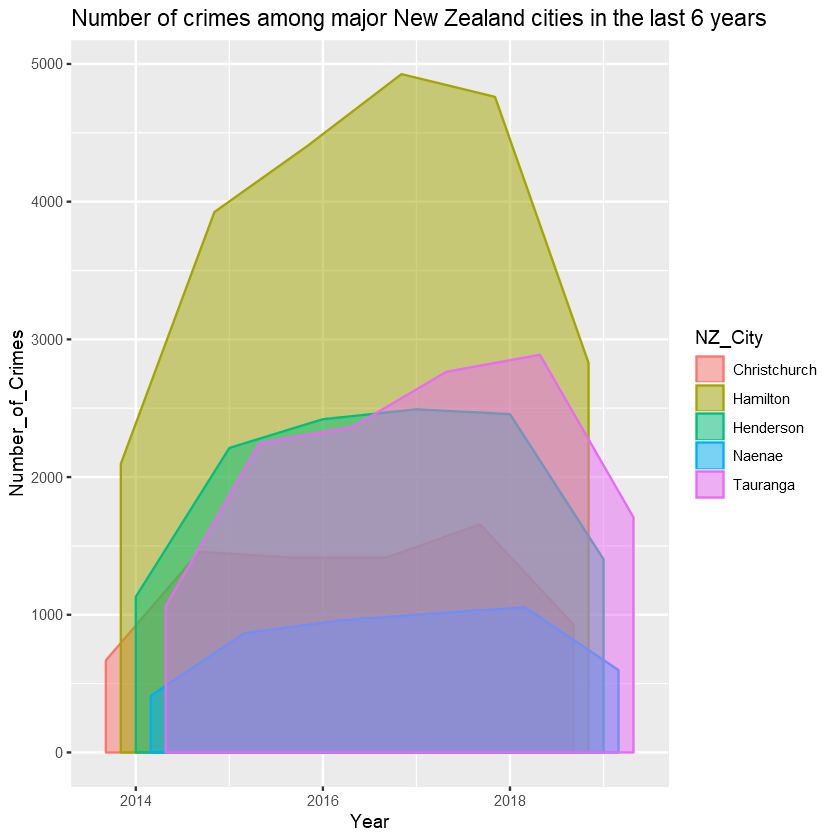

In [23]:
#A area chart that compares the number of crimes among major New Zealand cities in the last 6 years.

ggplot(vis1_c, aes(x = Year, y = Number_of_Crimes)) + 
  geom_area(aes(color = NZ_City, fill = NZ_City), 
            alpha = 0.5, position = position_dodge(0.8)) +
  ggtitle("Number of crimes among major New Zealand cities in the last 6 years")

#### After executing this notebook, go to <b>`read_me.txt`</b> to execute the next notebook.

If you have `already executed` all the other notebooks, `then` go to `section -3 in 'IVS.pynb'` that has IVS data